In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import keras
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

In [ ]:
NUM_SAMPLE_POINTS = 1024
dataset_url = "https://git.io/JiY4i"

dataset_path = keras.utils.get_file(
    fname="shapenet.zip",
    origin=dataset_url,
    cache_subdir="datasets",
    hash_algorithm="auto",
    extract=True,
    archive_format="auto",
    cache_dir="datasets",
)

1078925405/1078925405 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step


In [ ]:
glob("/tmp/.keras/datasets/PartAnnotation/*")

['/tmp/.keras/datasets/PartAnnotation/03636649',
 '/tmp/.keras/datasets/PartAnnotation/03948459',
 '/tmp/.keras/datasets/PartAnnotation/02691156',
 '/tmp/.keras/datasets/PartAnnotation/02954340',
 '/tmp/.keras/datasets/PartAnnotation/03001627',
 '/tmp/.keras/datasets/PartAnnotation/04379243',
 '/tmp/.keras/datasets/PartAnnotation/04099429',
 '/tmp/.keras/datasets/PartAnnotation/03261776',
 '/tmp/.keras/datasets/PartAnnotation/03797390',
 '/tmp/.keras/datasets/PartAnnotation/synsetoffset2category.txt',
 '/tmp/.keras/datasets/PartAnnotation/04225987',
 '/tmp/.keras/datasets/PartAnnotation/03467517',
 '/tmp/.keras/datasets/PartAnnotation/03642806',
 '/tmp/.keras/datasets/PartAnnotation/02958343',
 '/tmp/.keras/datasets/PartAnnotation/02773838',
 '/tmp/.keras/datasets/PartAnnotation/03790512',
 '/tmp/.keras/datasets/PartAnnotation/03624134',
 '/tmp/.keras/datasets/PartAnnotation/README.txt',
 '/tmp/.keras/datasets/PartAnnotation/metadata.json']

In [ ]:
glob("/tmp/.keras/datasets/PartAnnotation/03624134/*")

['/tmp/.keras/datasets/PartAnnotation/03624134/points_label',
 '/tmp/.keras/datasets/PartAnnotation/03624134/expert_verified',
 '/tmp/.keras/datasets/PartAnnotation/03624134/user_annotations',
 '/tmp/.keras/datasets/PartAnnotation/03624134/points']

In [ ]:
glob("/tmp/.keras/datasets/PartAnnotation/03624134/points/*")

['/tmp/.keras/datasets/PartAnnotation/03624134/points/b382ba6ce202434bd3802c3145f560bc.pts',
 '/tmp/.keras/datasets/PartAnnotation/03624134/points/e6b32b3c927a7fbeae29387f6eb32067.pts',
 '/tmp/.keras/datasets/PartAnnotation/03624134/points/b61c9b5f29ad581c860a45e027159a9a.pts',
 '/tmp/.keras/datasets/PartAnnotation/03624134/points/4ad7d03773d3767c2bc52a80abcabb17.pts',
 '/tmp/.keras/datasets/PartAnnotation/03624134/points/75e32ddfd15d3ef1fd92188644609a39.pts',
 '/tmp/.keras/datasets/PartAnnotation/03624134/points/5663637633c938d1395331ebe4786cd.pts',
 '/tmp/.keras/datasets/PartAnnotation/03624134/points/d243969f5010c6c29b5844aa8fc56c71.pts',
 '/tmp/.keras/datasets/PartAnnotation/03624134/points/693c599683ba86a410240762b65ed973.pts',
 '/tmp/.keras/datasets/PartAnnotation/03624134/points/938a7a0692360ec853b59f50e41b1782.pts',
 '/tmp/.keras/datasets/PartAnnotation/03624134/points/bcd5c95026dff530542a1605686ede02.pts',
 '/tmp/.keras/datasets/PartAnnotation/03624134/points/308f294e2fd166f78

In [ ]:
f = open('/tmp/.keras/datasets/PartAnnotation/synsetoffset2category.txt', "r")
for i,x in enumerate(f):
    class_name, folder_name = x.split('\t')
    print(class_name)

Airplane
Bag
Cap
Car
Chair
Earphone
Guitar
Knife
Lamp
Laptop
Motorbike
Mug
Pistol
Rocket
Skateboard
Table


In [ ]:
f = open('/tmp/.keras/datasets/PartAnnotation/synsetoffset2category.txt', "r")
dict_mapping = {}
num_classes  = 3
for i,x in enumerate(f):
    class_name, folder_name = x.split('\t')
    if (class_name not in ['Table', 'Lamp', 'Laptop']):
        continue
    dict_mapping[folder_name[:-1]] = class_name
f.close()

In [ ]:
dict_mapping

{'03636649': 'Lamp', '03642806': 'Laptop', '04379243': 'Table'}

In [ ]:
point_clouds        = []
dense_labels        = []
code_index_mapping  =  {}
for i, class_name in enumerate(dict_mapping):
    point_files = glob(f'/tmp/.keras/datasets/PartAnnotation/{class_name}/points/*')
    num_object = 0
    for file in point_files:
        point_cloud = np.loadtxt(file)
        if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
            continue
        if num_object == 500:
            break
        shuffle = np.random.choice(point_cloud.shape[0], NUM_SAMPLE_POINTS, replace = False)
        point_cloud = point_cloud[shuffle]
        point_clouds.append(point_cloud)
        dense_labels.append(i)
        code_index_mapping[i] = dict_mapping[class_name]
        num_object += 1

In [ ]:
point_clouds[0].shape, point_clouds[1].shape

((1024, 3), (1024, 3))

In [ ]:
code_index_mapping

{0: 'Lamp', 1: 'Laptop', 2: 'Table'}

In [ ]:
point_clouds = np.stack(point_clouds)
dense_labels = np.stack(dense_labels)
# label_clouds = keras.utils.to_categorical(dense_labels, num_classes=3)
label_clouds = dense_labels
print(point_clouds.shape)
print(dense_labels.shape)

(1460, 1024, 3)
(1460,)


In [ ]:
class PointCloudData(Dataset):
    def __init__(self, point_clouds, label_clouds):
        self.point_clouds = point_clouds
        self.label_clouds = label_clouds

    def __len__(self):
        return point_clouds.shape[0]

    def __getitem__(self, idx):
        return {'pointcloud': torch.from_numpy(point_clouds[idx]),
                'category': torch.from_numpy(np.asarray(label_clouds[idx]))}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(point_clouds, label_clouds, test_size=0.2, random_state=42)

In [ ]:
train_loader = PointCloudData(X_train,y_train)
val_loader   = PointCloudData(X_val,y_val)

In [ ]:
train_loader = DataLoader(dataset=train_loader, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_loader, batch_size=32, shuffle=True)

In [ ]:
for i in train_loader:
    print(i['pointcloud'].shape)
    print(i['category'].shape)
    break

torch.Size([32, 1024, 3])
torch.Size([32])


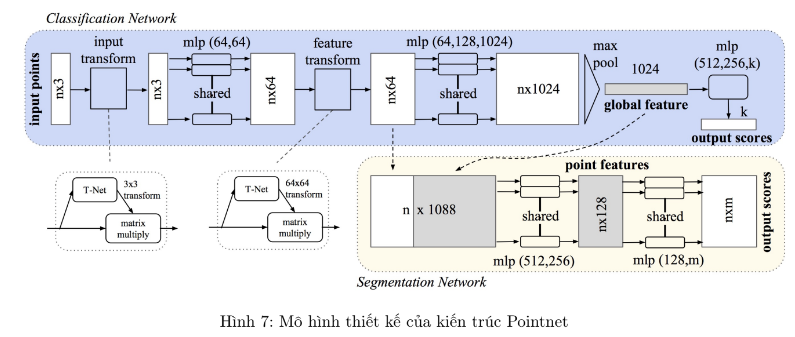

In PointNet, **T-net** plays an important role in achieving orientation invariance of the point
cloud. **T-net** is a subnetwork within PointNet that learns a transformation matrix. This transformation
matrix is ​​then applied to each point in the point cloud, essentially rotating the points.

By learning this transformation, the network can handle point clouds presented from different
perspectives.

**Stability and Initialization**:

If the T-net is initialized with zero values, the initial transformation will be a null
(unchanged) transformation. This can lead to instability during training, especially in the early stages.

The identity matrix represents a uniform transformation, which essentially leaves the points unchanged. Using the identity matrix for initialization provides a stable starting point for the T-net to learn meaningful transformations.

This allows the T-net to gradually deviate from the uniform transformation as it learns. This makes learning smoother and avoids sudden changes during training.

In [ ]:
class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)


   def forward(self, input): # (bs, 3, n)
      bs = input.size(0)

      xb = F.relu(self.bn1(self.conv1(input))) # [32, 64, 1024]
      xb = F.relu(self.bn2(self.conv2(xb))) # [32, 128, 1024]
      xb = F.relu(self.bn3(self.conv3(xb))) # [32, 1024, 1024]

      pool = nn.MaxPool1d(xb.size(-1))(xb) # torch.Size([32, 1024, 1]), Aggregation

      flat = nn.Flatten(1)(pool) # torch.Size([32, 1024])
      xb = F.relu(self.bn4(self.fc1(flat))) # torch.Size([32, 512])
      xb = F.relu(self.bn5(self.fc2(xb))) # torch.Size([32, 256])

      # initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()

      matrix = self.fc3(xb).view(-1,self.k,self.k) + init # [32, 3, 3]
      return matrix

In [ ]:
input = torch.randn(32, 3, 1024)
tnet = Tnet(3)
a =tnet(input)

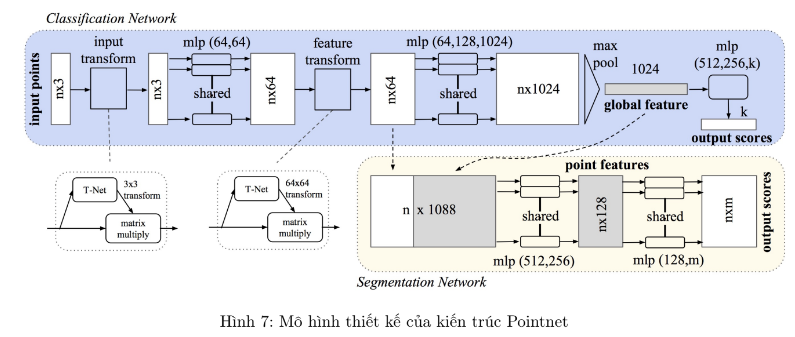

In [ ]:
class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

   def forward(self, input): # [32, 3, 1024]
        matrix3x3 = self.input_transform(input) # # torch.Size([32, 3, 3])
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2) # torch.Size([32, 3, 1024])
        xb = F.relu(self.bn1(self.conv1(xb))) # torch.Size([32, 64, 1024])

        matrix64x64 = self.feature_transform(xb) # torch.Size([32, 64, 64])
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2) # torch.Size([32, 64, 1024])
        xb = F.relu(self.bn2(self.conv2(xb))) # torch.Size([32, 128, 1024])

        xb = self.bn3(self.conv3(xb)) # torch.Size([32, 1024, 1024])
        xb = nn.MaxPool1d(xb.size(-1))(xb) # torch.Size([32, 1024, 1])
        output = nn.Flatten(1)(xb) # torch.Size([32, 1024])
        return output, matrix3x3, matrix64x64

In [ ]:
class PointNet(nn.Module):
    def __init__(self, classes = 3):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)


        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)

        return self.logsoftmax(output), matrix3x3, matrix64x64

* **Distance preservation:** Orthogonal matrices have the special property of preserving the distances between points. This means that when an orthogonal matrix is ​​applied to a point cloud, the relative shape of the points is not distorted, only rotated. This is a very important property in 3D object recognition problems, because we want the network to learn the inherent geometric features of the object, not the features that depend on the coordinate system.
* **Numerical stability:** Orthogonal matrices have the property of inversion by transposition. This makes the calculations involving orthogonal matrices more stable, especially when performing inverse calculations. This improves the stability of the network during training and reduces overfitting problems.
* **Computational efficiency:** As mentioned, computing the inverse of an orthogonal matrix is ​​simply computing the transposition. This significantly reduces computational costs, especially when dealing with large point clouds.

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)

    # Encourages the network to learn transformations that preserve the inherent structure of the point cloud and improve generalization
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)

    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()

    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))

    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
pointnet = PointNet(classes = num_classes)
pointnet.to(device);
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

def train(model, train_loader, val_loader=None,  epochs=5, save=True):
    for epoch in range(epochs):
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)

            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2)) ############

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)


        torch.save(pointnet.state_dict(), "save_"+str(epoch)+".pth")

In [ ]:
train(pointnet, train_loader, val_loader,  save=True)

[Epoch: 1, Batch:   10 /   46], loss: 0.417
[Epoch: 1, Batch:   20 /   46], loss: 0.108
[Epoch: 1, Batch:   30 /   46], loss: 0.105
[Epoch: 1, Batch:   40 /   46], loss: 0.134
Valid accuracy: 92 %
[Epoch: 2, Batch:   10 /   46], loss: 0.147
[Epoch: 2, Batch:   20 /   46], loss: 0.101
[Epoch: 2, Batch:   30 /   46], loss: 0.111
[Epoch: 2, Batch:   40 /   46], loss: 0.136
Valid accuracy: 98 %
[Epoch: 3, Batch:   10 /   46], loss: 0.103
[Epoch: 3, Batch:   20 /   46], loss: 0.060
[Epoch: 3, Batch:   30 /   46], loss: 0.045
[Epoch: 3, Batch:   40 /   46], loss: 0.031
Valid accuracy: 98 %
[Epoch: 4, Batch:   10 /   46], loss: 0.063
[Epoch: 4, Batch:   20 /   46], loss: 0.082
[Epoch: 4, Batch:   30 /   46], loss: 0.077
[Epoch: 4, Batch:   40 /   46], loss: 0.056
Valid accuracy: 97 %
[Epoch: 5, Batch:   10 /   46], loss: 0.067
[Epoch: 5, Batch:   20 /   46], loss: 0.039
[Epoch: 5, Batch:   30 /   46], loss: 0.053
[Epoch: 5, Batch:   40 /   46], loss: 0.126
Valid accuracy: 99 %


In [ ]:
import shutil

for i in range(5):
  source = "/content/save_"+str(i)+".pth"
  destination = "/content/drive/MyDrive/Quang/School/Semester 7/DAT/Lab1/save_"+str(i)+".pth"
  shutil.move(source, destination)

In [ ]:
model = PointNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/Quang/School/Semester 7/DAT/Lab1/save_4.pth'))

<ipython-input-29-41be6c734782>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Quang/School/Semester 7/DAT/Lab1/sa

<All keys matched successfully>

In [ ]:
def visualize_data_classification(point_cloud, predict, gt):
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    ax.scatter(
        point_cloud[:, 0],point_cloud[:, 2],point_cloud[:, 1])
    ax.set_title(f"Predict {predict} - Ground truth {gt}")
    plt.show()

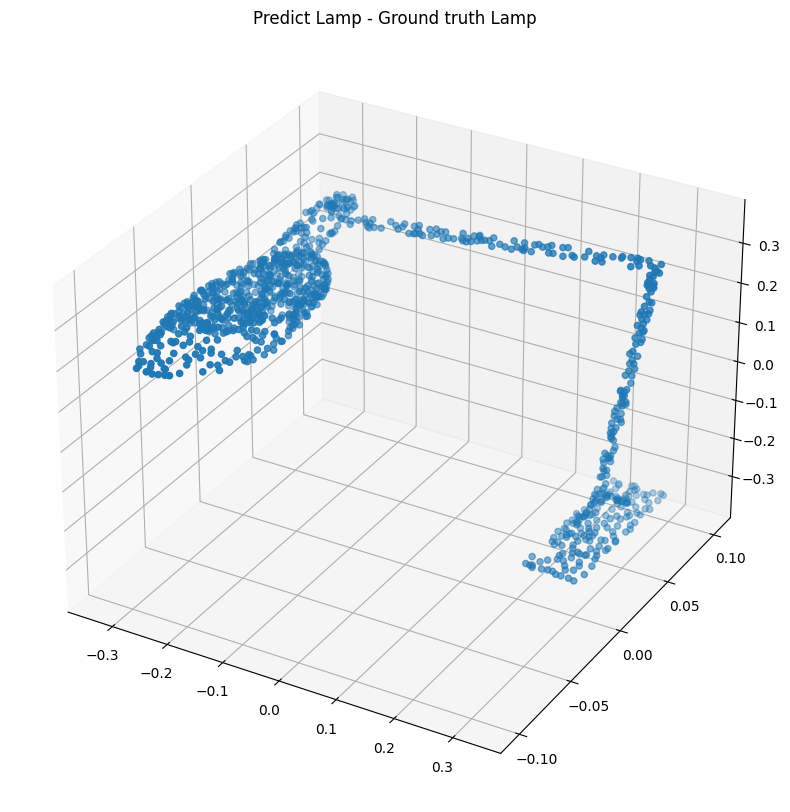

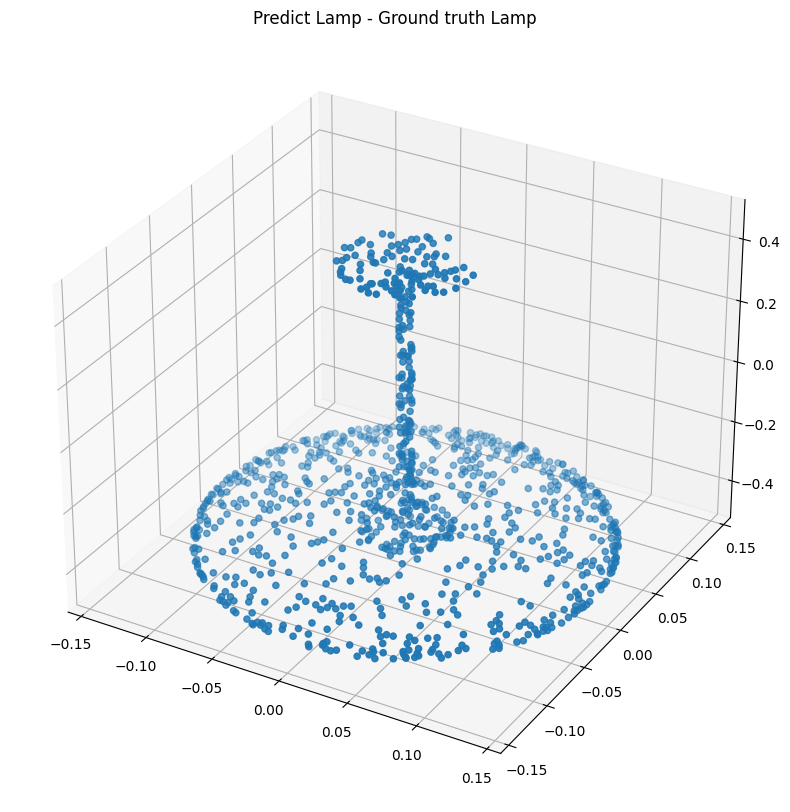

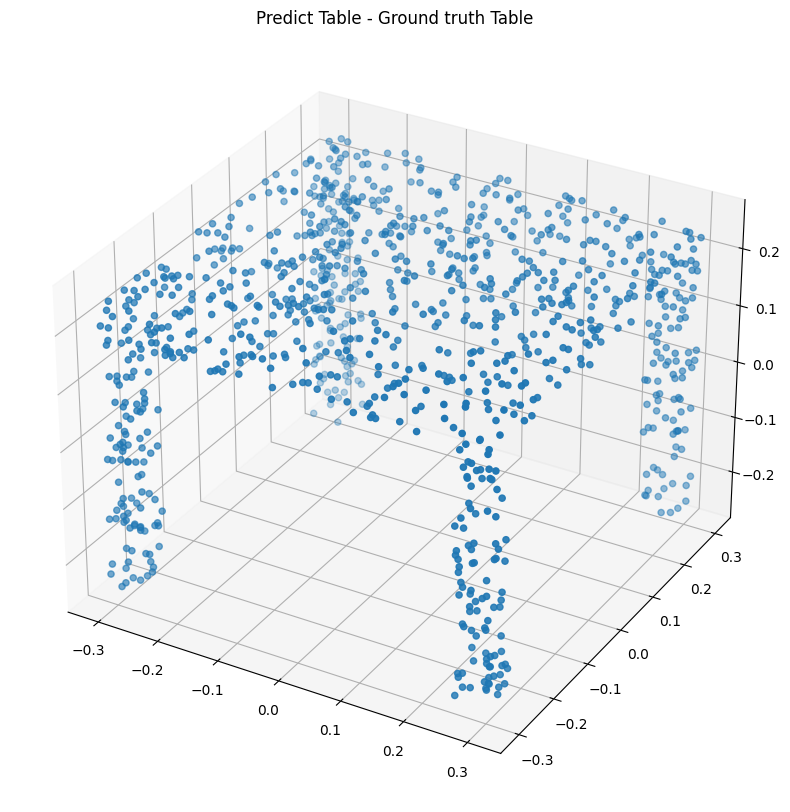

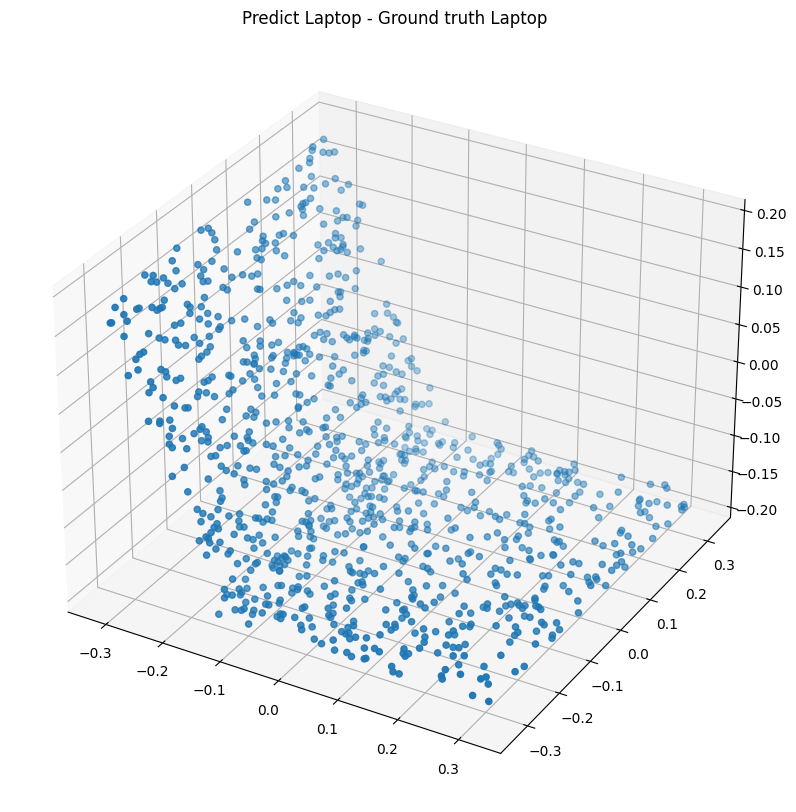

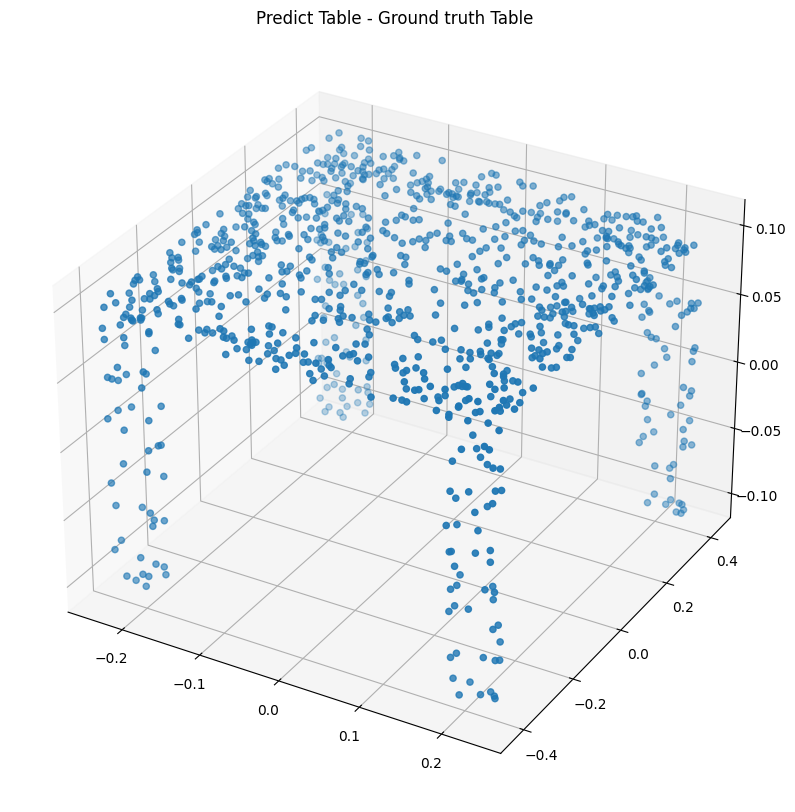

In [ ]:
for i, data in enumerate(val_loader, 0):
    inputs, gt = data['pointcloud'].to(device).float(), data['category'].tolist()

    outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))
    predict_class_id = torch.argmax(outputs, dim = 1).tolist()
    predict_class_name = [code_index_mapping[x] for x in predict_class_id]
    gt_class_name      = [code_index_mapping[x] for x in gt]
    for j in range(5):
        visualize_data_classification(inputs.cpu().numpy()[j], predict_class_name[j], gt_class_name[j])
    break